In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive"

 a4_generative_v1
 assignment3
'Colab Notebooks'
 CSU_backup
 DEEPLEARNINGFINAL
 Doordash_Resume_DS_Mark_Gardner.gdoc
 GTech.zip
 links-simple-sorted.zip
 SupremeCourt
'Tractor_Supply_DS_Mark_Gardner (1).docx'
 Untitled0.ipynb
'Untitled document.gdoc'


In [5]:
import os
os.chdir('/content/drive/MyDrive/DEEPLEARNINGFINAL/DeepLearningFinal/drop_layers_analysis')

In [3]:
!ls

dropping_layers.ipynb  dropping_layers.py  results.csv


In [6]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torchvision.models import resnet50, vit_b_16, vit_b_32
# from tqdm.autonotebook import tqdm
from copy import deepcopy
# from cka import CKACalculator
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = (7, 7)
import sys
import os

# get the root project folder (one level up from the notebook)
project_root = os.path.abspath("..")
sys.path.append(project_root)

from CNN import CNN
from VisionTransormer import VisionTransformer

# config
import yaml

config = yaml.safe_load(open('../config.yaml'))
cnn_config = config['cnn']
vt_config = config['vision_transformer']



In [7]:
device = torch.device(
    'cuda' if torch.cuda.is_available() else
    'mps' if torch.backends.mps.is_available() else
    'cpu'
)
device


device(type='cuda')

In [8]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [9]:
transform = Compose([
    Resize(224),
    ToTensor(),
    Normalize(mean=(0.485, 0.456, 0.406),
              std=(0.229, 0.224, 0.225))
])

train_dataset = CIFAR10(root='../data', train=True, download=True, transform=transform)
test_dataset  = CIFAR10(root='../data', train=False, download=True, transform=transform)

batch_size = config['batch_size']

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

len(train_dataset), len(test_dataset)
from torch.utils.data import Subset
import numpy as np

train_percent = 1.0
test_percent = 1.0
# train_percent = .025
# test_percent = .025

# compute subset sizes
train_size = int(len(train_dataset) * train_percent)
test_size = int(len(test_dataset) * test_percent)

# create random subset indices
train_indices = np.random.choice(len(train_dataset), train_size, replace=False)
test_indices = np.random.choice(len(test_dataset), test_size, replace=False)

# create subsets
training_data_small = Subset(train_dataset, train_indices)
test_data_small = Subset(test_dataset, test_indices)

# new loaders (keeping same batch size)
train_loader = DataLoader(training_data_small, batch_size=config['batch_size'], shuffle=True)
test_loader = DataLoader(test_data_small, batch_size=config['batch_size'], shuffle=False)


In [10]:
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# quick sanity check later:
model = CNN(cnn_config, device)
# count_trainable_params(model)
model_vit = VisionTransformer(vt_config, device)



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 166MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

100%|██████████| 330M/330M [00:02<00:00, 136MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [11]:
def make_cnn(num_layers_to_drop: int):
    cfg = dict(cnn_config)           # shallow copy
    cfg['num_layers_to_drop'] = num_layers_to_drop
    return CNN(cfg, device)

def make_vit(num_encoder_layers_to_drop: int):
    cfg = dict(vt_config)
    cfg['num_encoder_layers_to_drop'] = num_encoder_layers_to_drop
    return VisionTransformer(cfg, device)


In [15]:
import time

def run_training(model, num_epochs, train_loader, test_loader, print_freq):
    history = {
        "epoch": [],
        "test_accuracy": [],
        "train_loss": [],
        "test_loss": [],
        "total_time": None,
    }

    start_time = time.time()

    for epoch in range(num_epochs):
        train_loss_running = 0.0
        # ---- train loop (same as main.py) ----
        for batch_idx, batch in enumerate(train_loader):
            loss = model.training_step(batch)
            # print(f"Losss = {loss}")
            train_loss_running += loss.item()
            # train_loss_running += loss

            if batch_idx % print_freq == 0:
                print(f"Epoch {epoch}, Batch {batch_idx}, Train Loss: {loss.item():.4f}")
        avg_train_loss = train_loss_running / len(train_loader)


        # ---- test loop (same as main.py, but we compute total manually) ----
        test_loss = 0.0
        correct = 0.0
        total = 0

        for batch_idx, batch in enumerate(test_loader):
            batch_loss, batch_correct = model.test_step(batch)
            test_loss += batch_loss
            correct += batch_correct
            # batch[0] are the images
            total += batch[0].size(0)

        test_loss /= len(test_loader)
        accuracy = correct / total

        print(
            f"Test Error for Epoch {epoch}: "
            f"Accuracy: {100 * accuracy:>0.1f}%, Avg train loss: {avg_train_loss:>8f}, Avg loss: {test_loss:>8f}\n"
        )

        # ---- log history ----
        history["epoch"].append(epoch)
        history["test_accuracy"].append(float(accuracy))
        history["train_loss"].append(float(avg_train_loss))
        history["test_loss"].append(float(test_loss))

    history["total_time"] = time.time() - start_time
    return history


In [16]:
import time

num_epochs = config['num_epochs']
print_freq = config['print_batch_frequency']

cnn_drop_list = [0, 1, 2]
vit_drop_list = [0, 4, 8]
# # cnn_drop_list = [0, 2]
# # vit_drop_list = [0, 8]
# cnn_drop_list = [ 0]
# vit_drop_list = [0]

results = []

for num_drop in cnn_drop_list:
    model = make_cnn(num_drop)

    # initialize LazyLinear
    dummy = next(iter(train_loader))[0].to(device)
    with torch.no_grad():
        _ = model(dummy)

    n_params = count_trainable_params(model)
    start_time = time.time()
    history = run_training(model, num_epochs, train_loader, test_loader, print_freq)
    total_time = time.time() - start_time

    results.append({
        "model": "cnn",
        "layers_dropped": num_drop,
        "params": n_params,
        "history": history,
        "run_time": total_time
    })

for num_drop in vit_drop_list:
    model = make_vit(num_drop)

    dummy = next(iter(train_loader))[0].to(device)
    with torch.no_grad():
        _ = model(dummy)

    n_params = count_trainable_params(model)
    start_time = time.time()

    history = run_training(model, num_epochs, train_loader, test_loader, print_freq)
    total_time = time.time() - start_time

    results.append({
        "model": "vit",
        "layers_dropped": num_drop,
        "params": n_params,
        "history": history,
        "run_time": total_time
    })


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
results

[{'model': 'cnn',
  'layers_dropped': 0,
  'params': 5130,
  'history': {'epoch': [0, 1, 2, 3, 4],
   'test_accuracy': [0.568, 0.732, 0.684, 0.72, 0.76],
   'train_loss': [2.772767204046249,
    0.9511301815509796,
    0.7972605705261231,
    0.6334061846137047,
    0.5252502143383027],
   'test_loss': [1.1926891803741455,
    0.819324865937233,
    0.8158683925867081,
    0.7515385895967484,
    0.6875943541526794],
   'total_time': 19.235700845718384},
  'run_time': 19.23597502708435},
 {'model': 'vit',
  'layers_dropped': 0,
  'params': 7690,
  'history': {'epoch': [0, 1, 2, 3, 4],
   'test_accuracy': [0.104, 0.104, 0.128, 0.148, 0.148],
   'train_loss': [2.3716368556022642,
    2.3460482358932495,
    2.316844379901886,
    2.291571283340454,
    2.2636924028396606],
   'test_loss': [2.335839867591858,
    2.309402644634247,
    2.282421290874481,
    2.255856156349182,
    2.2297794818878174],
   'total_time': 100.23840379714966},
  'run_time': 100.23868680000305}]

In [6]:
import pandas as pd

# Save results
# df = pd.DataFrame(results)
# df.to_csv("results.csv", index=False)

# Load data if not running training/test
df = pd.read_csv("results.csv")
df

,model,layers_dropped,params,history,run_time
0,cnn,0,5130,"{'epoch': [0, 1, 2, 3, 4], 'test_accuracy': [0...",565.422677
1,cnn,1,2570,"{'epoch': [0, 1, 2, 3, 4], 'test_accuracy': [0...",557.870891
2,cnn,2,1290,"{'epoch': [0, 1, 2, 3, 4], 'test_accuracy': [0...",550.384731
3,vit,0,7690,"{'epoch': [0, 1, 2, 3, 4], 'test_accuracy': [0...",3798.422031
4,vit,4,7690,"{'epoch': [0, 1, 2, 3, 4], 'test_accuracy': [0...",2576.991419
5,vit,8,7690,"{'epoch': [0, 1, 2, 3, 4], 'test_accuracy': [0...",1362.832726


In [7]:
# If not training, if loading in data, convert back to dictionary.
results_dict = df.to_dict(orient="records")
results_dict

[{'model': 'cnn',
  'layers_dropped': 0,
  'params': 5130,
  'history': "{'epoch': [0, 1, 2, 3, 4], 'test_accuracy': [0.6615, 0.7549, 0.775, 0.7843, 0.7685], 'test_loss': [1.2966504655066569, 0.8501172983532499, 0.7861799316801084, 0.7407089398734888, 0.8427643982847784], 'total_time': 565.4224102497101}",
  'run_time': 565.4226770401001},
 {'model': 'cnn',
  'layers_dropped': 1,
  'params': 2570,
  'history': "{'epoch': [0, 1, 2, 3, 4], 'test_accuracy': [0.6462, 0.6731, 0.6984, 0.7111, 0.7203], 'test_loss': [1.102686097287828, 0.9796873862576333, 0.8995744650530967, 0.8495902077407594, 0.8272157455705533], 'total_time': 557.8706164360046}",
  'run_time': 557.8708908557892},
 {'model': 'cnn',
  'layers_dropped': 2,
  'params': 1290,
  'history': "{'epoch': [0, 1, 2, 3, 4], 'test_accuracy': [0.4861, 0.5068, 0.5306, 0.5468, 0.5596], 'test_loss': [1.5431132126765645, 1.4379592078506567, 1.3757733562190062, 1.3288300409438505, 1.296421536214792], 'total_time': 550.3844890594482}",
  'run_t

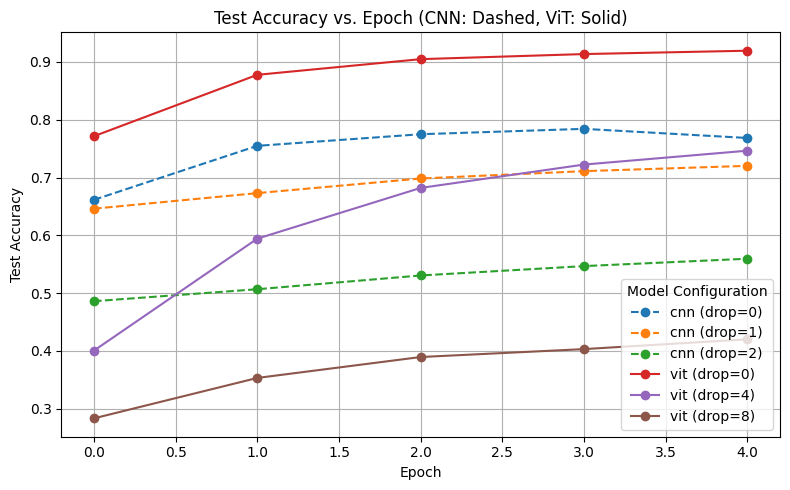

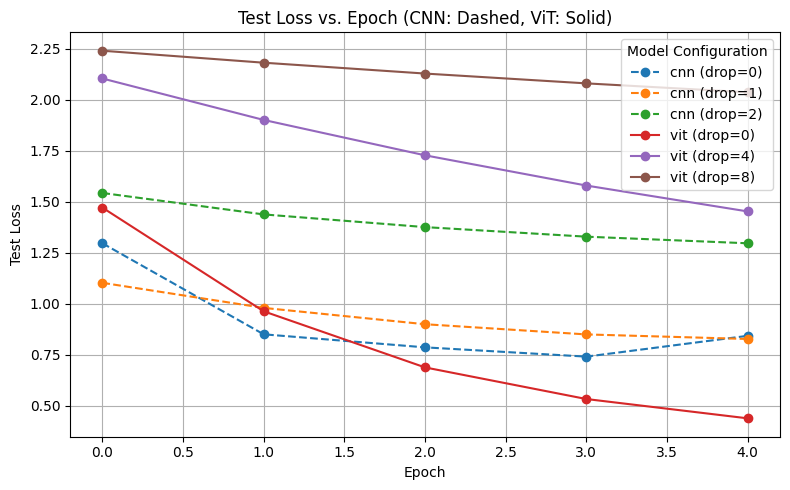

In [9]:
import matplotlib.pyplot as plt
import ast

results = results_dict

# Define a mapping for line styles based on the model type
LINE_STYLES = {
    'cnn': '--',    # Dashed line for CNN
    'vit': '-',     # Solid line for ViT
}



def plot_metric_over_epochs(results, metric="test_accuracy", title=None, ylabel=None):
    plt.figure(figsize=(8, 5))

    for r in results:
        # 1. Safely evaluate the history string to a dictionary
        h_string = r["history"]
        h = ast.literal_eval(h_string)

        epochs = h["epoch"]
        values = h[metric]
        model_type = r["model"]

        # 2. Get the linestyle based on the model type
        line_style = LINE_STYLES.get(model_type, ':') # Use ':' (dotted) as a fallback

        label = f"{model_type} (drop={r['layers_dropped']})"

        # 3. Pass the linestyle to plt.plot()
        plt.plot(epochs, values, marker="o", linestyle=line_style, label=label)

    plt.xlabel("Epoch")
    plt.ylabel(ylabel or metric)
    plt.title(title or f"{metric} vs epoch")
    plt.legend(title="Model Configuration")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Usage:
plot_metric_over_epochs(results, metric="test_accuracy",
                        title="Test Accuracy vs. Epoch (CNN: Dashed, ViT: Solid)",
                        ylabel="Test Accuracy")

plot_metric_over_epochs(results, metric="test_loss",
                        title="Test Loss vs. Epoch (CNN: Dashed, ViT: Solid)",
                        ylabel="Test Loss")

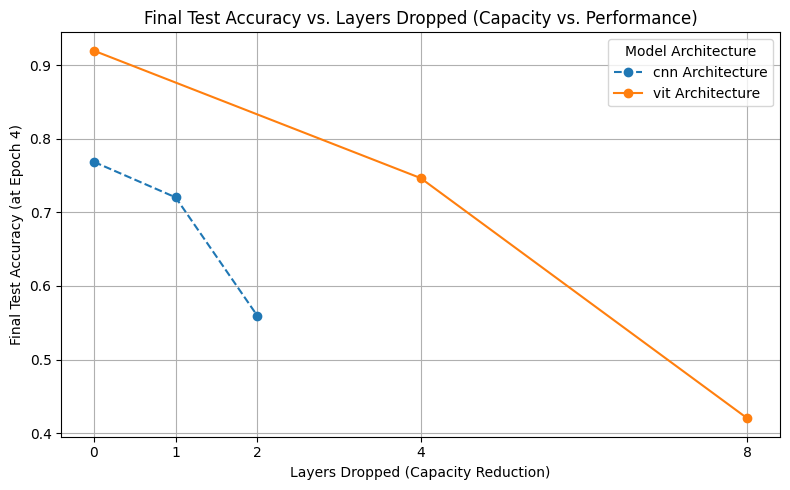

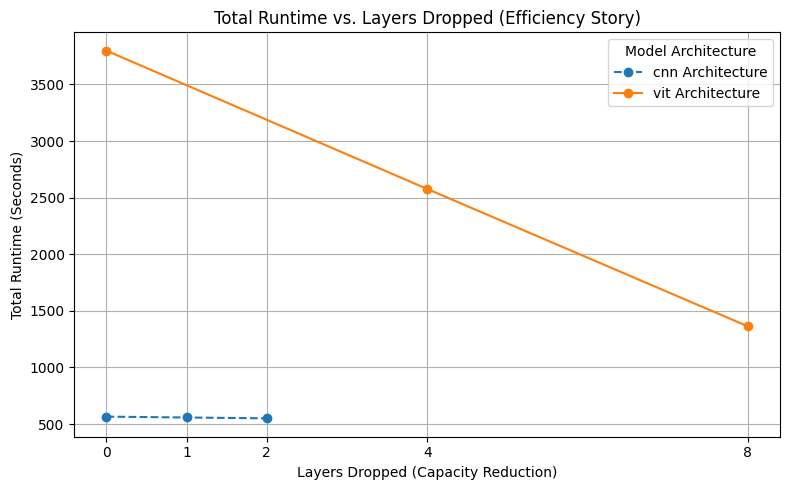

In [ ]:
import matplotlib.pyplot as plt
import ast # Necessary for safely converting the history string to a dictionary



# Define a mapping for line styles based on the model type
LINE_STYLES = {
    'cnn': '--',    # Dashed line for CNN
    'vit': '-',     # Solid line for ViT
}

def plot_summary_metrics(results, metric_key, title=None, ylabel=None):
    # Dictionary to hold data grouped by model type: {'cnn': {'x': [...], 'y': [...]}, ...}
    grouped_data = {}

    # 1. Process data and group by model
    for r in results:
        model = r['model']
        if model not in grouped_data:
            grouped_data[model] = {'x': [], 'y': []}

        layers_dropped = r['layers_dropped']

        # Determine the Y-value based on the requested metric
        if metric_key == 'final_accuracy':
            # Safely evaluate history string and get the last accuracy value
            h = ast.literal_eval(r["history"])
            y_value = h["test_accuracy"][-1]

        elif metric_key == 'runtime':
            # Use run_time directly
            y_value = r['run_time']
        else:
            continue

        # Collect data points
        grouped_data[model]['x'].append(layers_dropped)
        grouped_data[model]['y'].append(y_value)

    # 2. Plotting
    plt.figure(figsize=(8, 5))

    # Collect all unique layers_dropped values for X-axis ticks
    x_ticks = sorted(list(set([r['layers_dropped'] for r in results])))

    # Iterate through models to plot them with the correct style
    for model, data in grouped_data.items():
        # Combine x and y, sort by x (layers_dropped), then unpack for clean line plotting
        sorted_points = sorted(zip(data['x'], data['y']))
        x_sorted = [point[0] for point in sorted_points]
        y_sorted = [point[1] for point in sorted_points]

        line_style = LINE_STYLES.get(model, ':')

        plt.plot(x_sorted, y_sorted,
                 marker="o",
                 linestyle=line_style,
                 label=f"{model} Architecture")

    plt.xlabel("Layers Dropped (Capacity Reduction)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(title="Model Architecture")
    plt.grid(True)
    plt.xticks(x_ticks) # Set ticks to show all tested layers_dropped values
    plt.tight_layout()
    plt.show()

# --- USAGE ---

# 1. Final accuracy vs. layers dropped (Capacity vs Performance)
plot_summary_metrics(results, metric_key="final_accuracy",
                        title="Final Test Accuracy vs. Layers Dropped (Capacity vs. Performance)",
                        ylabel="Final Test Accuracy (at Epoch 4)")

# 2. Runtime vs. layers dropped (Efficiency Story)
plot_summary_metrics(results, metric_key="runtime",
                        title="Total Runtime vs. Layers Dropped (Efficiency Story)",
                        ylabel="Total Runtime (Seconds)")

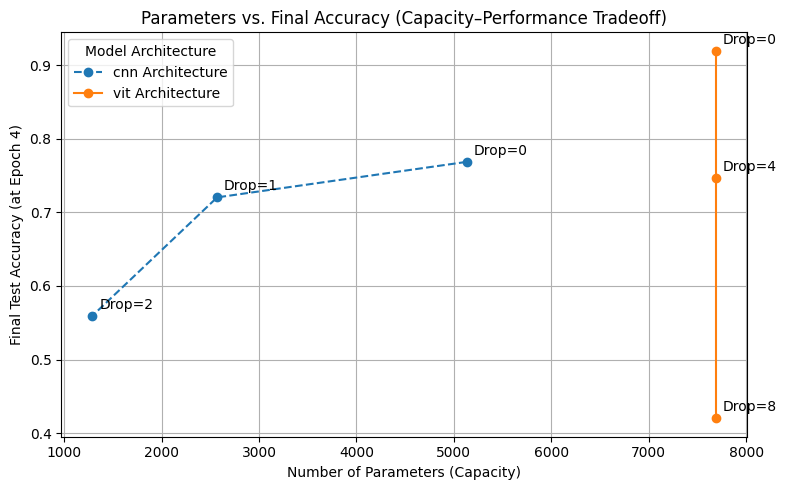

In [ ]:
import matplotlib.pyplot as plt
import ast



# Define a mapping for line styles based on the model type
LINE_STYLES = {
    'cnn': '--',    # Dashed line for CNN
    'vit': '-',     # Solid line for ViT
}

def plot_params_vs_accuracy(results, title=None, ylabel="Final Test Accuracy"):
    # Dictionary to hold data grouped by model type: {'cnn': {'x': [...], 'y': [...], 'labels': [...]}, ...}
    grouped_data = {}

    # 1. Process data and group by model
    for r in results:
        model = r['model']
        if model not in grouped_data:
            grouped_data[model] = {'x': [], 'y': [], 'labels': []}

        # X-axis: Parameters
        params = r['params']

        # Y-axis: Final Accuracy (Safely evaluate history and get the last accuracy value)
        h = ast.literal_eval(r["history"])
        y_value = h["test_accuracy"][-1]

        # Collect data points
        grouped_data[model]['x'].append(params)
        grouped_data[model]['y'].append(y_value)
        # Store the layers_dropped value for annotation
        grouped_data[model]['labels'].append(r['layers_dropped'])

    # 2. Plotting
    plt.figure(figsize=(8, 5))

    # Iterate through models to plot them with the correct style
    for model, data in grouped_data.items():
        line_style = LINE_STYLES.get(model, ':')

        # Plot scatter points and connect them to show the capacity path
        plt.plot(data['x'], data['y'],
                 marker="o",
                 linestyle=line_style,
                 label=f"{model} Architecture")

        # Annotate points with layers_dropped value for context
        for x, y, drop in zip(data['x'], data['y'], data['labels']):
            plt.annotate(f"Drop={drop}",
                         (x, y),
                         textcoords="offset points",
                         xytext=(5,5),
                         ha='left')

    plt.xlabel("Number of Parameters (Capacity)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(title="Model Architecture")
    plt.grid(True)
    # Ensure X-axis shows full numbers (not scientific notation)
    plt.ticklabel_format(style='plain', axis='x')
    plt.tight_layout()
    plt.show()

# Usage call for the requested plot:
plot_params_vs_accuracy(results,
                        title="Parameters vs. Final Accuracy (Capacity–Performance Tradeoff)",
                        ylabel="Final Test Accuracy (at Epoch 4)")